
Importing libraries

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

import os

from mpl_toolkits.mplot3d import Axes3D
from time import time

# Set data type
DTYPE='float32'
#DTYPE='float64'
tf.keras.backend.set_floatx(DTYPE)
print('TensorFlow version used: {}'.format(tf.__version__))

TensorFlow version used: 2.15.0


In [2]:
# Final time
T = tf.constant(1., dtype=DTYPE)

# Spatial dimensions
dim = 1

# Domain-of-interest at t=0
a = 0 * tf.ones((dim), dtype=DTYPE)
b = 160 * tf.ones((dim), dtype=DTYPE)

# Interest rate
r = tf.constant(1./20, dtype=DTYPE)

# Drift
mu = tf.constant(0, dtype=DTYPE)

# Strike price
K = tf.constant(40., dtype=DTYPE)

# Diffusion/volatility
sigma = tf.constant(0.2, dtype=DTYPE)

# Define terminal condition, i.e., payoff at maturity
def fun_g(x):
    return tf.exp(-r*T) * tf.maximum(tf.reduce_max(x, axis=1, keepdims=True) - K, 0.)




In [3]:
def init_model(dim, activation='tanh',
               num_hidden_neurons=100,
               num_hidden_layers=2,
               initializer=tf.keras.initializers.GlorotUniform()):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(dim))
    model.add(tf.keras.layers.BatchNormalization(epsilon=1e-6))
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_hidden_neurons,
                                activation=None,
                                use_bias=False,
                                kernel_initializer=initializer
                                ))
        model.add(tf.keras.layers.BatchNormalization(epsilon=1e-6))
        model.add(tf.keras.layers.Activation(activation))

    model.add(tf.keras.layers.Dense(1,
                                    activation=None,
                                    use_bias=False,
                                    kernel_initializer=initializer
                                    ))
    model.add(tf.keras.layers.BatchNormalization(epsilon=1e-6))

    return model

In [4]:
def init_pinns(num_hidden_layers=8, num_neurons_per_layer=100):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # Input is two-dimensional (time + one spatial dimension)
    model.add(tf.keras.Input(2))

    # Introduce a scaling layer to map input to [lb, ub]
    scaling_layer = tf.keras.layers.Lambda(
                lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
    #model.add(scaling_layer)

    # Append first hidden layer
    model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('leaky_relu'),
            kernel_initializer='glorot_normal', dtype=tf.float64))

    # Append remaining hidden layers
    for _ in range(num_hidden_layers - 1):
        model.add(tf.keras.layers.BatchNormalization(dtype=tf.float64))
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('tanh'),
            kernel_initializer='glorot_normal', dtype=tf.float64))

    # Output is one-dimensional
    model.add(tf.keras.layers.Dense(1, dtype=tf.float64))

    return model


In [5]:
def loss_fn(X, y, model, training=False):
    """ This function computes the mean squared error between the current model
    prediction model(X) and the values y.
    Inputs:
        X - approximation to the state process X
        y - target value
        model - model of neural network approximating x -> u(T,x)
        training - boolean flag to indicate training
    """

    X0 = X[:,:,0]
    y_pred = model(X0, training)

    # Return mean squared error
    return tf.reduce_mean(tf.math.squared_difference(y, y_pred))

In [6]:
@tf.function
def compute_grad(X, y, model, training=False):
    """ This function computes the gradient of the loss function w.r.t.
    the trainable variables theta.
    Inputs:
        X - approximation to the state process X
        y - target value
        model - model of neural network approximating x -> u(T,x)
        training - boolean flag to indicate training
    """
    with tf.GradientTape() as tape:
        loss = loss_fn(X, y, model, training)
    grad = tape.gradient(loss, model.trainable_variables)
    return loss, grad

Generating Data

In [7]:

@tf.function
def draw_X(num_samples, a, b):
    """ Function to draw num_samples many pairs of uniformly drawn starting
    values X_0 and end points X_T of a stochastic process X with zero drift and
    constant scalar diffusion. Starting points are drawn uniformly from the
    hypercube [a,b] \\subset \mathbb{R}^d. """
    dim = a.shape[0]

    X0 = a + tf.random.uniform((num_samples, dim), dtype=DTYPE) * (b-a)

    # Initialize the array X
    xi = tf.random.normal(shape=(num_samples, dim), dtype=DTYPE)
    XT = X0 * tf.exp( (r - tf.square(sigma)/2) * T + sigma * tf.sqrt(T) * xi)

    # Return simulated paths as well as increments of Brownian motion
    return tf.stack([X0, XT], 2)



def dw(delta_t):
    return tf.random.normal(loc = 0.0,scale = tf.sqrt(delta_t))




In [8]:
# Initialize model
model = init_model(dim=dim, num_hidden_neurons=dim+100, num_hidden_layers=3, activation='relu')

# Set up step size
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([2501,5001],[1e-3,1e-4,1e-5])

# Set number of training epochs
num_epochs = 500001

# Set batch size
batch_size = 8192

# Choose an optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=lr, epsilon=1e-8)

# Initialize list containing history of losses
hist_loss = []
error_hist = []

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 1)                 4         
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 101)               101       
                                                                 
 batch_normalization_1 (Bat  (None, 101)               404       
 chNormalization)                                                
                                                                 
 activation (Activation)     (None, 101)               0         
                                                                 
 dense_1 (Dense)             (None, 101)               10201     
                                                                 
 batch_normalization_2 (Bat  (None, 101)               4

Draw a test set with 250 000 samples and estimate the target values by means of Monte-Carlo estimation with $32 \times 32 000$ samples.

In [ ]:
# Randomly choose a test set from \mathcal{D} to approximate
# errors by means of Monte Carlo sampling
n_test = 25000
X = draw_X(n_test, a, b)
Xtest = X[:,:,0]
Xtest = tf.convert_to_tensor(Xtest, dtype=DTYPE)

# Prepare Ytest
Ytest = tf.zeros((Xtest.shape[0],1),dtype=DTYPE)

# Determine values at Xtest through Monte-Carlo sampling
# Set batch size and mc_samples, results in b_size*mc_samples many iterates
b_size = 32
mc_samples = 3200


@tf.function
def mc_step(y):
    # Draw standard normal random variables
    Xi = tf.random.normal(shape=(b_size, dim), dtype=DTYPE)
    # Determine update
    upd = tf.exp( (r- tf.square(sigma)/2) * T + sigma * tf.sqrt(T) * Xi)
    # Determine X_T
    XT = tf.reshape(Xtest, shape=[n_test, dim, 1])*tf.transpose(upd)
    return y + tf.reduce_sum(tf.reshape(fun_g(XT),[n_test, b_size]), axis=1,keepdims=True)/(b_size*mc_samples)

for i in range(mc_samples):
    if i%100==0:
         print(i,'/',mc_samples)
    Ytest=mc_step(Ytest)

print(Ytest)
####Other Method for generating Test Set
N = norm.cdf




0 / 3200
100 / 3200
200 / 3200
300 / 3200
400 / 3200
500 / 3200
600 / 3200
700 / 3200
800 / 3200
900 / 3200
1000 / 3200
1100 / 3200
1200 / 3200
1300 / 3200
1400 / 3200
1500 / 3200
1600 / 3200
1700 / 3200
1800 / 3200
1900 / 3200
2000 / 3200
2100 / 3200
2200 / 3200
2300 / 3200
2400 / 3200
2500 / 3200
2600 / 3200
2700 / 3200
2800 / 3200
2900 / 3200
3000 / 3200
3100 / 3200
tf.Tensor(
[[2.1002447e+01]
 [2.3302828e+01]
 [6.8687469e+01]
 ...
 [0.0000000e+00]
 [1.7722552e-03]
 [7.5267014e+01]], shape=(25000, 1), dtype=float32)


In [ ]:
@tf.function
def CALL(S, K, T, r, sigma):
    d0 = (tf.math.log(S / K) + (r - sigma**2 / 2) * T) / (sigma * tf.math.sqrt(T))
    d1 = d0 - sigma * tf.math.sqrt(T)
    norm_dist = tfp.distributions.Normal(0, 1)
    return S * norm_dist.cdf(d0) - K * tf.math.exp(-r * T) * norm_dist.cdf(d1)

#print(CALL(100,K,T,r,sigma))
Ytest = CALL(Xtest,K,T,r,sigma)
print(Ytest)

tf.Tensor(
[[2.0941704e+01]
 [2.3242714e+01]
 [6.8595795e+01]
 ...
 [8.8918781e-14]
 [1.3832022e-03]
 [7.5169769e+01]], shape=(25000, 1), dtype=float32)


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

path = '/content/drive/My Drive/Weights_folder/Weights'

model.load_weights(path)




Mounted at /content/drive


In [ ]:
# Define a training step as a TensorFlow function to increase speed of training
@tf.function
def train_step():
    # Draw batch of random paths
    X = draw_X(batch_size, a, b)



    # Evaluate g at X_T
    y = fun_g(X[:,:,-1])

    # And compute the loss as well as the gradient
    loss, grad = compute_grad(X, y, model, training=True)
    #hist_loss.append(loss)

    # Perform gradient step
    optimizer.apply_gradients(zip(grad, model.trainable_variables))
    return loss

# Start timer
t0 = time()


# Set interval to estimate errors
log_interval = 1000

num_epochs = 3000001
# Initialize header of output
print('  Iter        Loss   L1_rel   L2_rel   Linf_rel |   L1_abs   L2_abs   Linf_abs  |    Time')
# Loop to train model
for i in range(num_epochs):

    # Perform training step
    loss = train_step()
    hist_loss.append(loss)

    if i % log_interval == 0:

        # Compute current prediction on test set
        Ypred = model(Xtest, training=False)

        # Compute absolute and relative errors
        abs_error = np.abs(Ypred - Ytest)
        rel_error = abs_error/Ytest
        L2_rel = tf.sqrt(tf.reduce_mean(tf.pow(rel_error, 2))).numpy()
        L1_rel = tf.reduce_mean(tf.abs(rel_error)).numpy()
        Linf_rel = tf.reduce_max(tf.abs(rel_error)).numpy()

        L2_abs = tf.sqrt(tf.reduce_mean(tf.pow(abs_error, 2))).numpy()
        L1_abs = tf.reduce_mean(tf.abs(abs_error)).numpy()
        Linf_abs = tf.reduce_max(tf.abs(abs_error)).numpy()

        total_time = time()-t0
        err = (i, loss.numpy(), L1_rel, L2_rel, Linf_rel, L1_abs, L2_abs, Linf_abs, total_time)
        error_hist.append(err)

        print('{:5d} {:12.4f} {:8.4f} {:8.4f}   {:8.4f} | {:8.4f} {:8.4f}   {:8.4f}  |  {:6.1f}'.format(*err))

model.save_weights(path)
#Y = model.call((X,dw))
print(time()-t0)


  Iter        Loss   L1_rel   L2_rel   Linf_rel |   L1_abs   L2_abs   Linf_abs  |    Time
    0    1969.1560      inf      inf        inf |  35.3201  42.8395    64.9269  |     5.7
 1000    1646.1755      inf      inf        inf |  31.3041  36.3496    65.8850  |     9.7
 2000    1621.0720      inf      inf        inf |  30.5642  35.2479    63.7383  |    14.4
 3000    1608.1780      inf      inf        inf |  30.3810  35.1736    64.1897  |    18.0
 4000    1661.0483      inf      inf        inf |  30.4569  35.2970    64.6378  |    21.6
 5000    1630.1886      inf      inf        inf |  30.3591  35.0126    63.7491  |    26.5
 6000    1551.6907      inf      inf        inf |  30.1915  34.8981    63.5291  |    30.2
 7000    1630.6741      inf      inf        inf |  30.1156  34.8477    63.5288  |    33.9
 8000    1560.3877      inf      inf        inf |  30.2023  34.9197    63.6499  |    38.1
 9000    1589.7959      inf      inf        inf |  30.1417  34.8391    63.4424  |    42.4
10000    1

In [ ]:
model.save_weights(path)

In [ ]:

ss = np.linspace(0,160,500)
ss_tensor = tf.convert_to_tensor(ss,dtype=DTYPE)

# Reshape the tensor to add a vector dimension
ss = tf.reshape(ss_tensor, [-1, 1])

tt = np.array([0.75]*ss.shape[0])
pred = []

for s in ss :
    pred.append(model(s,training = False))



In [ ]:
pred_l = [tensor.numpy() for tensor in pred]
pred_l = np.array(pred).reshape(-1)

bs = CALL(ss,K,T,r,sigma)


@tf.function
def mc_step(y):
    # Draw standard normal random variables
    Xi = tf.random.normal(shape=(b_size, dim), dtype=DTYPE)
    # Determine update
    upd = tf.exp( (r- tf.square(sigma)/2) * T + sigma * tf.sqrt(T) * Xi)
    # Determine X_T
    XT = tf.reshape(ss, shape=[500, dim, 1])*tf.transpose(upd)
    return y + tf.reduce_sum(tf.reshape(fun_g(XT),[500, b_size]), axis=1,keepdims=True)/(b_size*mc_samples)


mcc =  tf.zeros((ss.shape[0],1),dtype=DTYPE)
for i in range(mc_samples):
    if i%100==0:
         print(i,'/',mc_samples)
    mcc=mc_step(mcc)


print(mcc)

0 / 3200
100 / 3200
200 / 3200
300 / 3200
400 / 3200
500 / 3200
600 / 3200
700 / 3200
800 / 3200
900 / 3200
1000 / 3200
1100 / 3200
1200 / 3200
1300 / 3200
1400 / 3200
1500 / 3200
1600 / 3200
1700 / 3200
1800 / 3200
1900 / 3200
2000 / 3200
2100 / 3200
2200 / 3200
2300 / 3200
2400 / 3200
2500 / 3200
2600 / 3200
2700 / 3200
2800 / 3200
2900 / 3200
3000 / 3200
3100 / 3200
tf.Tensor(
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.0

In [ ]:
# Let's load the pinns model to compare it here with these methods
path_pinns = '/content/drive/My Drive/Weights_folder/PINN_dim1'

pinns = init_pinns()

pinns.load_weights(path_pinns)


ss = np.linspace(0,160,500)
tt = np.array([0.75]*ss.shape[0])
pred_pinns = []
for s,t in zip(ss,tt) :
    pred_pinns.append(pinns(np.array([[t, s]])).numpy().flatten()[0])


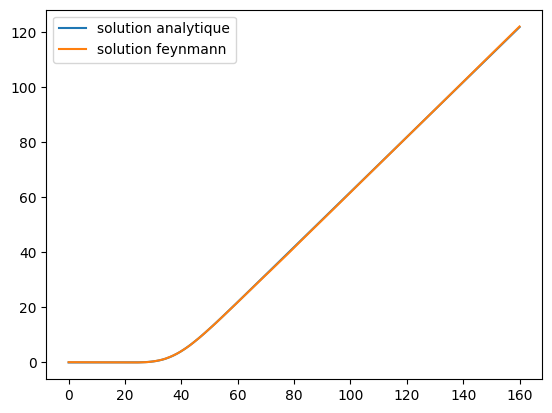

In [ ]:

mcc_numpy = mcc.numpy()
mcc_numpy = np.array(mcc_numpy)
mcc_numpy = mcc_numpy.flatten()

plt.plot(ss,bs,label = 'solution analytique')
plt.plot(ss,pred_l,label ='solution feynmann')
#plt.plot(ss,mcc_numpy,label ='solution mc')
#plt.plot(ss,pred_pinns,label="solution pinns")
plt.legend()

Text(0, 0.5, 'training loss')

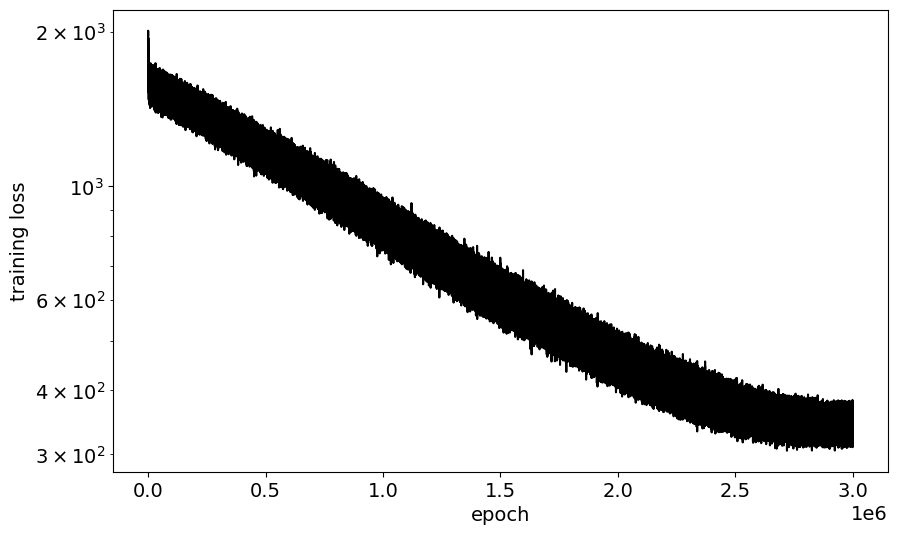

In [ ]:
  # Drawing the loss history
  plt.rcParams.update({'font.size': 14})

  fig, ax = plt.subplots(1,1,figsize=(10,6))
  ax.semilogy(range(len(hist_loss)), hist_loss,'k-')
  ax.set_xlabel('epoch')
  ax.set_ylabel('training loss')

(<matplotlib.legend.Legend at 0x7897f0333370>,)

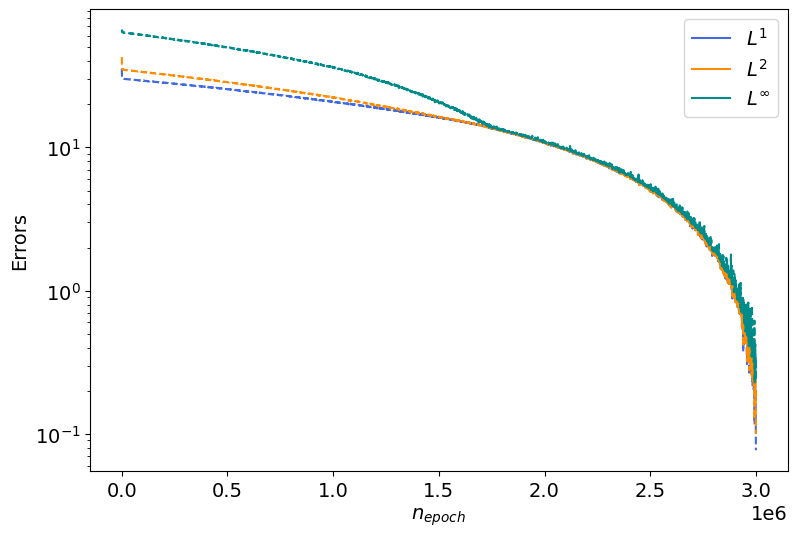

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(9,6))
ax.set_prop_cycle(color=['royalblue', 'darkorange', 'darkcyan'])
start_idx = 0
xrange = [e[0] for e in error_hist[start_idx:]]
ax.semilogy(xrange, [e[2:5] for e in error_hist[start_idx:]])
ax.semilogy(xrange, [e[5:8] for e in error_hist[start_idx:]], linestyle='--')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('Errors')
ax.legend(['$L^1$', '$L^2$', '$L^{\infty}$']),
#plt.savefig('Errors_HeatEquation_dim_{:03d}_{:s}.pdf'.format(dim,suffix), bbox_inches='tight', dpi=300)